In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import os
import platform
import sys

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
import torch
print(torch.__version__)

2.2.0+cu121


In [5]:
import torchtext
print(torchtext.__version__)

0.17.0+cpu


In [6]:
from torchtext.vocab import GloVe
from torchtext.data.utils import get_tokenizer

In [7]:
glove = GloVe(name='6B', dim=100)  # 100-dimensional GloVe embeddings

In [8]:
#  Setting Path to Dataset
def check_if_colab():
    if 'google.colab' in sys.modules:
        return True
    return False

In [9]:
if check_if_colab():
    print("Running on Google Colab")
    # from google.colab import drive
    # drive.mount('/content/drive')
    # BASE_PATH_TO_DATASETS='/content/drive/MyDrive/OMSCS/cs7641/All assignments/Assignments/Assignment-1'
    # BASE_PATH_TO_DATASETS=os.path.join(BASE_PATH_TO_DATASETS,'pubg')
else:
  if platform.system().lower().__contains__('windows'):
      BASE_PATH_TO_PROJECT_REPOSITORY=(os.sep).join(os.getcwd().split(os.sep)[:os.getcwd().split(os.sep).index('Parsec_Assignment')+1])
      BASE_PATH_TO_DATASETS=os.path.join(BASE_PATH_TO_PROJECT_REPOSITORY,'dataset')
      BASE_PATH_TO_CODE_BASE =os.path.join(BASE_PATH_TO_DATASETS, 'code_base')

  elif platform.system().lower().__contains__('linux'):
      BASE_PATH_TO_PROJECT_REPOSITORY=(os.sep).join(os.getcwd().split(os.sep)[:os.getcwd().split(os.sep).index('Parsec_Assignment')+1])
      BASE_PATH_TO_DATASETS=os.path.join(BASE_PATH_TO_PROJECT_REPOSITORY,'dataset')
      BASE_PATH_TO_CODE_BASE=os.path.join(BASE_PATH_TO_PROJECT_REPOSITORY, 'code_base')
  else:
      print('OS Error')
os.listdir(BASE_PATH_TO_DATASETS)

['DataSet.xlsx',
 'modified_dataset.xlsx',
 'modified_dataset_v1.xlsx',
 'modified_dataset_v2.xlsx',
 'modified_dataset_v3.xlsx',
 'modified_testing_df.csv',
 'modified_training_df.csv']

#### Loading Dataset

In [10]:
training_data = pd.read_csv(os.path.join(BASE_PATH_TO_DATASETS, 'modified_training_df.csv'))
testing_data = pd.read_csv(os.path.join(BASE_PATH_TO_DATASETS, 'modified_testing_df.csv'))

In [11]:
tokenizer = get_tokenizer("basic_english")

In [12]:
# Tokenize the dataset
training_data['tokenized_text'] = training_data['pdf_text_sample_cleaned'].apply(tokenizer)

In [13]:

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(training_data['tokenized_text'], training_data['target_col'], 
                                                    test_size=0.1,
                                                    random_state=42,
                                                    stratify=training_data['target_col']
                                                    )

# X_train= pd.DataFrame(X_train, columns=['pdf_text_sample_cleaned'])
# X_val= pd.DataFrame(X_val, columns=['pdf_text_sample_cleaned'])
X_train.shape, X_val.shape, y_train.shape, y_val.shape  

((1255,), (140,), (1255,), (140,))

In [14]:
X_train

168     [intelligent, position, modular, connector, te...
293     [series, fast, acting, compliant, halogen, fre...
704     [flexible, low, loss, cable, time, cable, high...
1294    [description, type, ohm, jacket, technical, da...
214     [description, semirigid, microwave, dimension,...
                              ...                        
243     [spec, sheet, data, reference, electrical, var...
152     [small, size, inrush, current, compliant, file...
182     [subject, change, without, notice, power, seri...
1264    [acting, fuse, series, size, compliant, quick,...
516     [scale, sheet, rev, name, size, cage, code, dr...
Name: tokenized_text, Length: 1255, dtype: object

In [15]:
# Encode labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

### Embedding Based Classification

In [16]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch

In [17]:
from torchtext.vocab import build_vocab_from_iterator

# Token generator to yield tokens from training data
def yield_tokens(data_iter):
    for tokens in data_iter:
        yield tokens

# Build vocabulary from iterator
vocab = build_vocab_from_iterator(yield_tokens(X_train), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])

In [18]:
def pad_sequence(seq, max_len=100):
    if len(seq) > max_len:
        return seq[:max_len]
    return seq + [vocab['<pad>']] * (max_len - len(seq))

In [19]:
# X_train = [pad_sequence(text) for text in X_train]
# X_val = [pad_sequence(text) for text in X_val]

In [20]:
np.array(X_train).shape

(1255,)

In [21]:
embedding_matrix = torch.zeros(len(vocab), 100)

for i, word in enumerate(vocab.get_itos()):
    if word in glove.stoi:
        embedding_matrix[i] = glove[word]
    else:
        embedding_matrix[i] = torch.randn(100)  # Random for unknown words

In [22]:
def numericalize_and_pad(texts, vocab, max_len=50):
    return [pad_sequence([vocab[token] for token in text], max_len) for text in texts]

In [23]:
X_train = numericalize_and_pad(X_train, vocab)
X_val = numericalize_and_pad(X_val, vocab)

In [24]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = [torch.tensor(text, dtype=torch.long) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [25]:
train_dataset = TextDataset(X_train, y_train_encoded)
val_dataset = TextDataset(X_val, y_val_encoded)
train_dataset

In [26]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [27]:
print(len(train_dataset.texts))  # Number of text samples
print(len(train_dataset.labels))  # Number of labels


1255
1255


In [28]:
# for i in range(len(train_dataset)):
#     print(train_dataset[i])  # This should print text and label pairs


In [29]:
for texts, labels in train_loader:
    print("Batch Text Shape:", texts.shape)
    print("Batch Label Shape:", labels.shape)
    break

Batch Text Shape: torch.Size([4, 50])
Batch Label Shape: torch.Size([4])


#### Modelling

In [30]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(LSTMClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])

In [31]:
embedding_dim = 100
hidden_dim = 128
output_dim = len(label_encoder.classes_)
vocab_size = len(vocab)
pad_idx = vocab['<pad>']

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [32]:
import matplotlib.pyplot as plt

def train(model, train_loader, test_loader, optimizer, criterion, epochs=10, patience=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)  # LR Decay
    best_val_loss = float('inf')
    no_improve_epochs = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0
        
        # Training
        for texts, labels in train_loader:
            optimizer.zero_grad()
            output = model(texts)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            # Calculate training accuracy
            predictions = torch.argmax(output, dim=1)
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)

        # Record Training Loss/Accuracy
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)
        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f}")

        # Validation
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for texts, labels in test_loader:
                output = model(texts)
                val_loss = criterion(output, labels)
                total_val_loss += val_loss.item()
                
                predictions = torch.argmax(output, dim=1)
                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)

        # Record Validation Loss/Accuracy
        val_losses.append(total_val_loss / len(test_loader))
        val_accuracies.append(correct_val / total_val)
        print(f"Validation Loss: {val_losses[-1]:.4f} | Validation Acc: {val_accuracies[-1]:.4f}")
        
        # LR Scheduler Step
        scheduler.step()

        # Early Stopping
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            no_improve_epochs = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break
    
    # Plot Accuracy and Loss
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1 | Train Loss: 0.8496 | Train Acc: 0.6622
Validation Loss: 0.4188 | Validation Acc: 0.8786
Epoch 2 | Train Loss: 0.5688 | Train Acc: 0.8024
Validation Loss: 0.3780 | Validation Acc: 0.8857
Epoch 3 | Train Loss: 0.2420 | Train Acc: 0.9355
Validation Loss: 0.1356 | Validation Acc: 0.9643
Epoch 4 | Train Loss: 0.1134 | Train Acc: 0.9705
Validation Loss: 0.1005 | Validation Acc: 0.9714
Epoch 5 | Train Loss: 0.0967 | Train Acc: 0.9745
Validation Loss: 0.0794 | Validation Acc: 0.9714
Epoch 6 | Train Loss: 0.0814 | Train Acc: 0.9769
Validation Loss: 0.0725 | Validation Acc: 0.9786
Epoch 7 | Train Loss: 0.0688 | Train Acc: 0.9801
Validation Loss: 0.0702 | Validation Acc: 0.9714
Epoch 8 | Train Loss: 0.0659 | Train Acc: 0.9809
Validation Loss: 0.0671 | Validation Acc: 0.9714
Epoch 9 | Train Loss: 0.0638 | Train Acc: 0.9809
Validation Loss: 0.0661 | Validation Acc: 0.9714
Epoch 10 | Train Loss: 0.0625 | Train Acc: 0.9809
Validation Loss: 0.0655 | Validation Acc: 0.9714
Epoch 11 | Train Lo

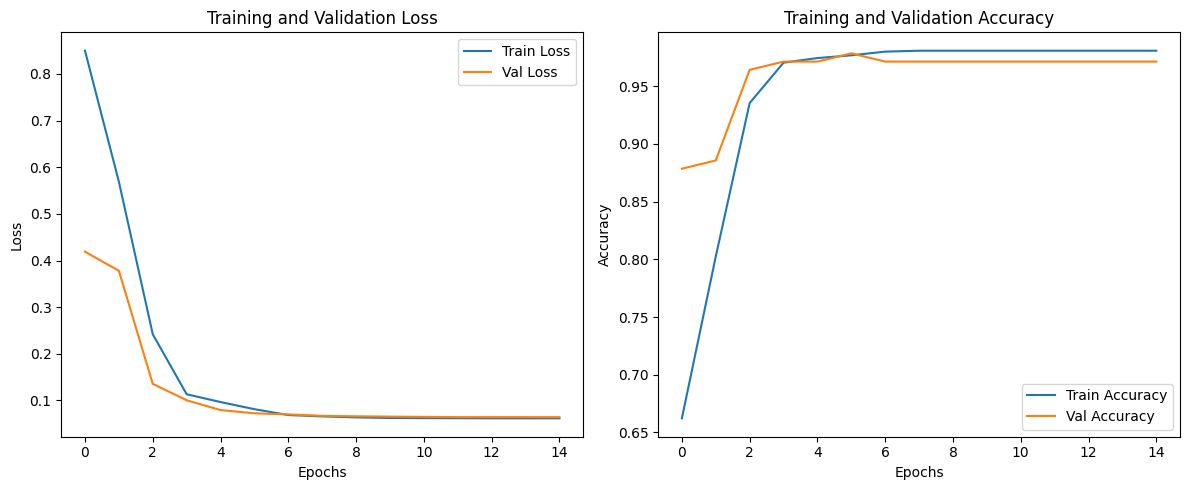

In [33]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=15, patience=5)

### Testing Data

In [34]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

In [35]:
testing_data['tokenized_text'] = testing_data['pdf_text_sample_cleaned'].apply(tokenizer)
testing_data['target_col_enc'] = label_encoder.transform(testing_data['target_col'])
testing_data.head()

,pdf_text_sample_cleaned,target_col,tokenized_text,target_col_enc
0,technical information lamp type number finish ...,lighting,"[technical, information, lamp, type, number, f...",2
1,fixture type number project location lighting ...,lighting,"[fixture, type, number, project, location, lig...",2
2,series slow blow surface mount compliant halog...,fuses,"[series, slow, blow, surface, mount, compliant...",1
3,fuse subject change without notice series fuse...,fuses,"[fuse, subject, change, without, notice, serie...",1
4,specification sheet part latest issue specific...,cable,"[specification, sheet, part, latest, issue, sp...",0


In [36]:
testing_data['numericalized_text'] = numericalize_and_pad(testing_data['tokenized_text'], vocab)
test_dataset = TextDataset(testing_data['numericalized_text'], testing_data['target_col_enc'])
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

Test Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97        90
           1       0.97      1.00      0.99       113
           2       0.94      0.84      0.89        61
           3       0.89      0.92      0.90        85

    accuracy                           0.95       349
   macro avg       0.94      0.93      0.94       349
weighted avg       0.95      0.95      0.94       349



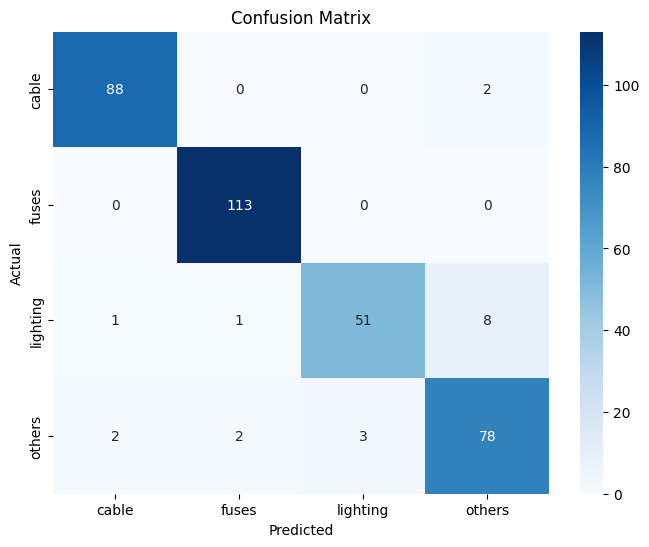

In [37]:
y_true = []
y_pred = []

with torch.no_grad():
    for texts, labels in test_loader:
        output = model(texts)
        predictions = torch.argmax(output, dim=1)
        
        # Extend using torch operations instead of numpy
        y_true.extend(labels.detach().cpu().tolist())
        y_pred.extend(predictions.detach().cpu().tolist())

# Print accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#### Saving Files

In [38]:
# Save the model
torch.save(model.state_dict(), './auxillary_files/lstm_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [39]:
# Save the vocabulary to a file
torch.save(vocab, './auxillary_files/vocab.pth')
print("Vocabulary saved successfully.")

Vocabulary saved successfully.


In [40]:
# Save the LabelEncoder to a file
torch.save(label_encoder.classes_, './auxillary_files/label_encoder.pth')
print("Label Encoder saved successfully.")

Label Encoder saved successfully.
